In [49]:
# 1. Import necessary libraries and load the datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Load the four CSV files for the two groups: No physical activity and Physical activity
no_train_df = pd.read_csv('diabetes_NoActivity_training.csv')   # NoActivity training data
no_test_df = pd.read_csv('diabetes_NoActivity_test.csv')        # NoActivity test data
phys_train_df = pd.read_csv('diabetes_PhysActivity_training.csv')  # PhysActivity training data
phys_test_df = pd.read_csv('diabetes_PhysActivity_test.csv')       # PhysActivity test data


In [50]:
# 2. Separate labels and features; perform initial feature selection for scatter analysis
# The 'Diabetes_binary' column is the target label (0 or 1 for diabetes status)
# Separate features (X) and labels (y) for each dataset
X_no_train = no_train_df.drop('Diabetes_binary', axis=1)
y_no_train = no_train_df['Diabetes_binary']
X_no_test = no_test_df.drop('Diabetes_binary', axis=1)
y_no_test = no_test_df['Diabetes_binary']

X_phys_train = phys_train_df.drop('Diabetes_binary', axis=1)
y_phys_train = phys_train_df['Diabetes_binary']
X_phys_test = phys_test_df.drop('Diabetes_binary', axis=1)
y_phys_test = phys_test_df['Diabetes_binary']


# At this point, X_no_train and X_phys_train contain only feature columns (e.g., BMI, GenHlth, etc.)
# y_no_train and y_phys_train contain the corresponding diabetes labels.
# For initial exploration, we consider the 'BMI' and 'Age' features for a scatter plot analysis.

# # No-Activity Training set
# plt.subplot(2, 2, 1)
# sns.scatterplot(x=X_no_train['BMI'], y=X_no_train['Age'], hue=y_no_train, palette='deep', alpha=1)
# plt.title('No Physical Activity: Training')
# plt.xlabel('BMI')
# plt.ylabel('Age')

# # No-Activity Test set
# plt.subplot(2, 2, 2)
# sns.scatterplot(x=X_no_test['BMI'], y=X_no_test['Age'], hue=y_no_test, palette='deep', alpha=1)
# plt.title('No Physical Activity: Test')
# plt.xlabel('BMI')
# plt.ylabel('Age')

# # Phys-Activity Training set
# plt.subplot(2, 2, 3)
# sns.scatterplot(x=X_phys_train['BMI'], y=X_phys_train['Age'], hue=y_phys_train, palette='deep', alpha=1)
# plt.title('Physical Activity: Training')
# plt.xlabel('BMI')
# plt.ylabel('Age')
# # Phys-Activity Test set
# plt.subplot(2, 2, 4)
# sns.scatterplot(x=X_phys_test['BMI'], y=X_phys_test['Age'], hue=y_phys_test, palette='deep', alpha=1)
# plt.title('Physical Activity: Test')
# plt.xlabel('BMI')
# plt.ylabel('Age')

# plt.tight_layout()
# plt.show()





In [51]:
# 3. Normalize features using StandardScaler for each group separately
# We fit the scaler on the training data for each group and use it to transform both training and test sets.
scaler_no = StandardScaler()
scaler_phys = StandardScaler()

# Fit on NoActivity training features and transform both train and test features
X_no_train_scaled = scaler_no.fit_transform(X_no_train)   # fit on train, transform train
X_no_test_scaled = scaler_no.transform(X_no_test)         # transform test using the same scaler

# Fit on PhysActivity training features and transform both train and test features
X_phys_train_scaled = scaler_phys.fit_transform(X_phys_train)  # fit on train, transform train
X_phys_test_scaled = scaler_phys.transform(X_phys_test)        # transform test using the same scaler
# # For No-Activity test set (assuming BMI is the first column)
# no_test_BMI = X_no_test_scaled[:, 0]
# print("No-Activity test BMI mean:", np.mean(no_test_BMI))
# print("No-Activity test BMI std:", np.std(no_test_BMI))

# # For Phys-Activity test set (assuming BMI is the first column)
# phys_test_BMI = X_phys_test_scaled[:, 0]
# print("Phys-Activity test BMI mean:", np.mean(phys_test_BMI))
# print("Phys-Activity test BMI std:", np.std(phys_test_BMI))

# The data is now standardized (zero mean, unit variance) within each group.
# This prevents features with larger scales from dominating and ensures comparability.
# Transform training data using PCA (already fit earlier as pca_no)
# X_phys_train_pca = pca_no.transform(X_no_train_scaled)

# plt.figure()
# sns.scatterplot(x=X_phys_train_pca[:, 0], y=X_phys_train_pca[:, 1], hue=y_phys_train, palette='deep', alpha=1)
# plt.title('Phys-Activity PCA: PC1 vs PC2(Training Data)')
# plt.xlabel('PC1 ')
# plt.ylabel('PC2 ')
# plt.savefig('fig3.png')
# plt.show()



In [52]:


# 4. PCA analysis on the scaled training data to find explained variance ratios
pca_no = PCA()  # PCA for NoActivity group
pca_no.fit(X_no_train_scaled)
explained_var_no = pca_no.explained_variance_ratio_  # array of variance ratios for each principal component

pca_phys = PCA()  # PCA for PhysActivity group
pca_phys.fit(X_phys_train_scaled)
explained_var_phys = pca_phys.explained_variance_ratio_  # variance ratios for PhysActivity group

# The explained variance ratio indicates the proportion of total variance explained by each principal component.
# For example, explained_var_no[0] is the variance explained by the first principal component on the NoActivity data.
# (We store these ratios for potential analysis; not printing them as per instructions.)



In [53]:
# 5. SVM for NoActivity Group (model training and evaluation)
# Split the NoActivity training set into a training subset (80%) and validation subset (20%) for hyperparameter tuning
X_no_tr, X_no_val, y_no_tr, y_no_val = train_test_split(
    X_no_train, y_no_train, test_size=0.2, random_state=42, stratify=y_no_train
)
# Note: stratify=y_no_train ensures the class distribution is roughly preserved in the split.

# Normalize both the training subset and validation subset using a new StandardScaler (fit on the training subset only)
scaler_no_sub = StandardScaler()
X_no_tr_scaled = scaler_no_sub.fit_transform(X_no_tr)  # fit on train subset, scale train subset
X_no_val_scaled = scaler_no_sub.transform(X_no_val)    # scale validation subset using train subset's scaler

# Train SVM models (RBF kernel) with different hyperparameter combinations and evaluate on validation set
# We'll try the following (C, gamma) pairs: (1,1), (5,0.5), (0.5,0.05)
param_combinations = [(1, 1), (5, 0.5), (0.5, 0.05)]
best_model_no = None
best_val_acc_no = 0.0
best_params_no = None

for C_val, gamma_val in param_combinations:
    # Create an SVM classifier with RBF kernel and given C and gamma
    svm_model = SVC(kernel='rbf', C=C_val, gamma=gamma_val)
    # Train the model on the NoActivity training subset
    svm_model.fit(X_no_tr_scaled, y_no_tr)
    # Compute accuracy on the validation subset
    val_accuracy = svm_model.score(X_no_val_scaled, y_no_val)
    # If this model has the highest validation accuracy so far, save it as the best model
    if val_accuracy > best_val_acc_no:
        best_val_acc_no = val_accuracy
        best_model_no = svm_model
        best_params_no = (C_val, gamma_val)

# After trying all combinations, best_model_no is the SVM with the highest validation accuracy
# best_params_no contains the (C, gamma) of that model, and best_val_acc_no is the accuracy on validation

# Evaluate the selected best model on the NoActivity test set
# We need to scale the test set using the same scaler that was fitted on the training subset
X_no_test_scaled_subset = scaler_no_sub.transform(X_no_test)   # normalize NoActivity test features with subset's scaler
test_accuracy_no = best_model_no.score(X_no_test_scaled_subset, y_no_test)
# The variable test_accuracy_no now holds the accuracy of the best NoActivity model on the NoActivity test data.


In [54]:
# 6. SVM for PhysActivity Group (model training and evaluation)
# Repeat the process for the PhysActivity group
# Split the PhysActivity training set into training (80%) and validation (20%) subsets
X_phys_tr, X_phys_val, y_phys_tr, y_phys_val = train_test_split(
    X_phys_train, y_phys_train, test_size=0.2, random_state=42, stratify=y_phys_train
)
# Normalize the PhysActivity training subset and validation subset
scaler_phys_sub = StandardScaler()
X_phys_tr_scaled = scaler_phys_sub.fit_transform(X_phys_tr)   # fit on phys train subset
X_phys_val_scaled = scaler_phys_sub.transform(X_phys_val)     # transform phys validation subset

# Train SVM models (RBF kernel) with the same set of (C, gamma) pairs on PhysActivity data
param_combinations = [(1, 1), (5, 0.5), (0.5, 0.05)]
best_model_phys = None
best_val_acc_phys = 0.0
best_params_phys = None

for C_val, gamma_val in param_combinations:
    svm_model = SVC(kernel='rbf', C=C_val, gamma=gamma_val)
    svm_model.fit(X_phys_tr_scaled, y_phys_tr)
    val_accuracy = svm_model.score(X_phys_val_scaled, y_phys_val)
    if val_accuracy > best_val_acc_phys:
        best_val_acc_phys = val_accuracy
        best_model_phys = svm_model
        best_params_phys = (C_val, gamma_val)

# best_model_phys is now the SVM that performed best on validation data for the PhysActivity group
# best_params_phys holds its (C, gamma) values, and best_val_acc_phys is the validation accuracy

# Evaluate the selected best PhysActivity model on the PhysActivity test set
X_phys_test_scaled_subset = scaler_phys_sub.transform(X_phys_test)  # normalize PhysActivity test features with subset's scaler
test_accuracy_phys = best_model_phys.score(X_phys_test_scaled_subset, y_phys_test)
# test_accuracy_phys holds the accuracy of the best PhysActivity model on the PhysActivity test data.


In [55]:
# 7. Cross-Model Evaluation
# Test the NoActivity-trained model on the PhysActivity test set, and vice versa, to see how they generalize across groups.

# Use the NoActivity model and its scaler on PhysActivity test data
X_phys_test_scaled_by_no = scaler_no_sub.transform(X_phys_test)  # scale PhysActivity test set using NoActivity scaler
cross_acc_no_on_phys = best_model_no.score(X_phys_test_scaled_by_no, y_phys_test)
# cross_acc_no_on_phys is the accuracy when the NoActivity-group model is applied to PhysActivity-group test data.

# Use the PhysActivity model and its scaler on NoActivity test data
X_no_test_scaled_by_phys = scaler_phys_sub.transform(X_no_test)  # scale NoActivity test set using PhysActivity scaler
cross_acc_phys_on_no = best_model_phys.score(X_no_test_scaled_by_phys, y_no_test)
# cross_acc_phys_on_no is the accuracy when the PhysActivity-group model is applied to NoActivity-group test data.

# The cross_acc values can be compared to the in-group test accuracies (test_accuracy_no and test_accuracy_phys)
# to evaluate how well each model generalizes to the other group's data.


NoActivity Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.62      0.68       152
         1.0       0.67      0.78      0.72       148

    accuracy                           0.70       300
   macro avg       0.71      0.70      0.70       300
weighted avg       0.71      0.70      0.70       300



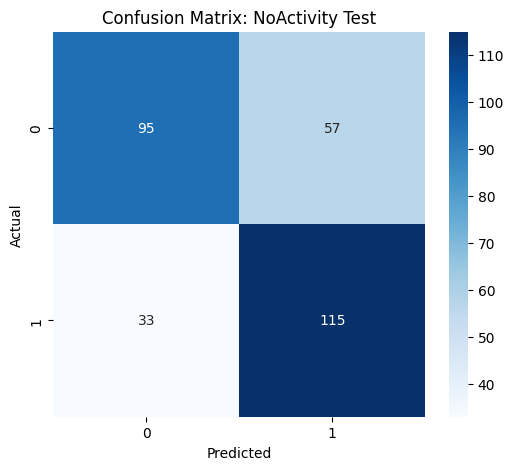

PhysActivity Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75       152
         1.0       0.73      0.83      0.78       148

    accuracy                           0.76       300
   macro avg       0.77      0.76      0.76       300
weighted avg       0.77      0.76      0.76       300



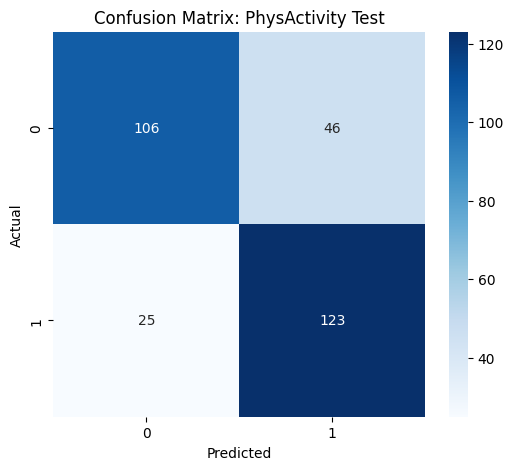

Cross-Evaluation (NoActivity model on PhysActivity Test) Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.82      0.75       152
         1.0       0.77      0.62      0.69       148

    accuracy                           0.72       300
   macro avg       0.73      0.72      0.72       300
weighted avg       0.73      0.72      0.72       300



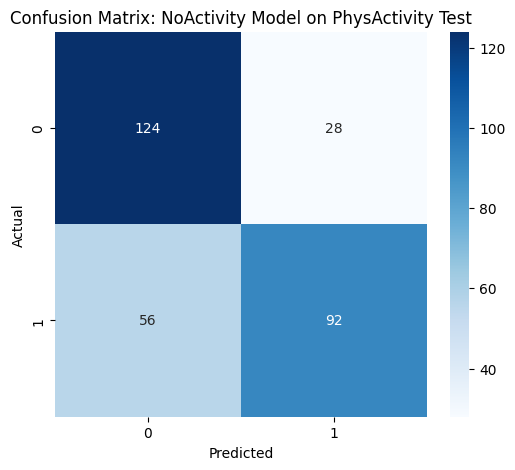

Cross-Evaluation (PhysActivity model on NoActivity Test) Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.46      0.60       152
         1.0       0.62      0.91      0.74       148

    accuracy                           0.68       300
   macro avg       0.73      0.69      0.67       300
weighted avg       0.73      0.68      0.67       300



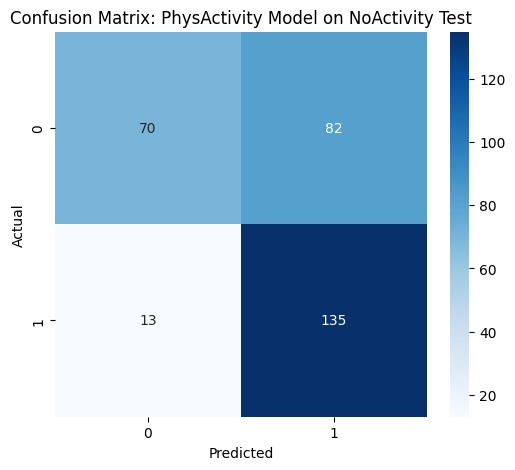

In [56]:

# Function to plot confusion matrix heatmap
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# SVM NoActivity Test Evaluation
X_no_test_scaled_subset = scaler_no_sub.transform(X_no_test)
y_no_pred = best_model_no.predict(X_no_test_scaled_subset)
cm_no = confusion_matrix(y_no_test, y_no_pred)
print("NoActivity Test Classification Report:")
print(classification_report(y_no_test, y_no_pred))
plot_confusion_matrix(cm_no, "Confusion Matrix: NoActivity Test")

# SVM PhysActivity Test Evaluation
X_phys_test_scaled_subset = scaler_phys_sub.transform(X_phys_test)
y_phys_pred = best_model_phys.predict(X_phys_test_scaled_subset)
cm_phys = confusion_matrix(y_phys_test, y_phys_pred)
print("PhysActivity Test Classification Report:")
print(classification_report(y_phys_test, y_phys_pred))
plot_confusion_matrix(cm_phys, "Confusion Matrix: PhysActivity Test")

# Cross-Model Evaluation: NoActivity model on PhysActivity Test Data
X_phys_test_scaled_by_no = scaler_no_sub.transform(X_phys_test)
y_cross_no_on_phys = best_model_no.predict(X_phys_test_scaled_by_no)
cm_cross_no_on_phys = confusion_matrix(y_phys_test, y_cross_no_on_phys)
print("Cross-Evaluation (NoActivity model on PhysActivity Test) Classification Report:")
print(classification_report(y_phys_test, y_cross_no_on_phys))
plot_confusion_matrix(cm_cross_no_on_phys, "Confusion Matrix: NoActivity Model on PhysActivity Test")

# Cross-Model Evaluation: PhysActivity model on NoActivity Test Data
X_no_test_scaled_by_phys = scaler_phys_sub.transform(X_no_test)
y_cross_phys_on_no = best_model_phys.predict(X_no_test_scaled_by_phys)
cm_cross_phys_on_no = confusion_matrix(y_no_test, y_cross_phys_on_no)
print("Cross-Evaluation (PhysActivity model on NoActivity Test) Classification Report:")
print(classification_report(y_no_test, y_cross_phys_on_no))
plot_confusion_matrix(cm_cross_phys_on_no, "Confusion Matrix: PhysActivity Model on NoActivity Test")
